In [17]:
import pandas as pd
import numpy as np
import mne


In [39]:
# data
labels_file = "./data/labels.csv"
data_file = "./data/DE-002.txt"

In [19]:
# labels
labels_df = pd.read_csv(labels_file)

# filter to keep only EEG channels (description is 'EEG')
eeg_labels = labels_df[(labels_df['description'] == 'EEG')]

# extract the relevant channel indices for EEG (C001 to C021)
eeg_channel_indices = [f"C{str(i).zfill(3)}" for i in range(1, 22)]

In [40]:
# load the data file
data_lines = []
with open(data_file, "r", encoding="UTF-16") as f:
    for line in f:
        if not line.startswith("%"): # skip comment lines
            data_lines.append(line.strip())

# parse the data into a DataFrame
columns = ["Date.Time", "EB", "Stamp"] + [f"C{str(i).zfill(3)}" for i in range(1, 36)] + ["PHOTIC"]

data = pd.DataFrame([line.split("\t") for line in data_lines], columns=columns)

# convert numeric columns to floats
for col in eeg_channel_indices:
    data[col] = pd.to_numeric(data[col], errors="coerce")

# extract EEG data
eeg_data = data[eeg_channel_indices].values.T # transpose for MNE compatibility

Creating RawArray with float64 data, n_channels=21, n_times=3312
    Range : 0 ... 3311 =      0.000 ...    13.244 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


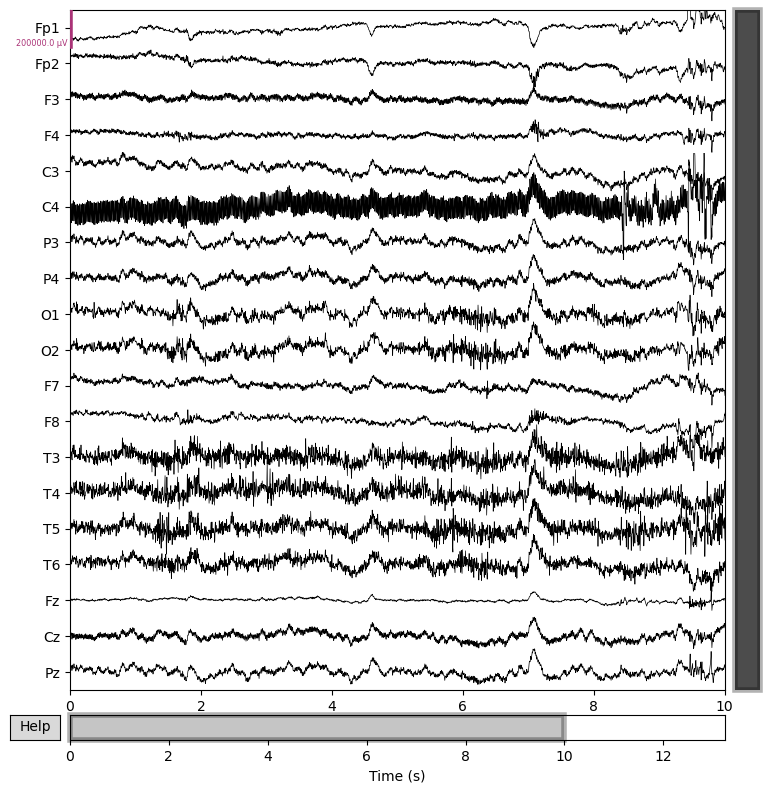

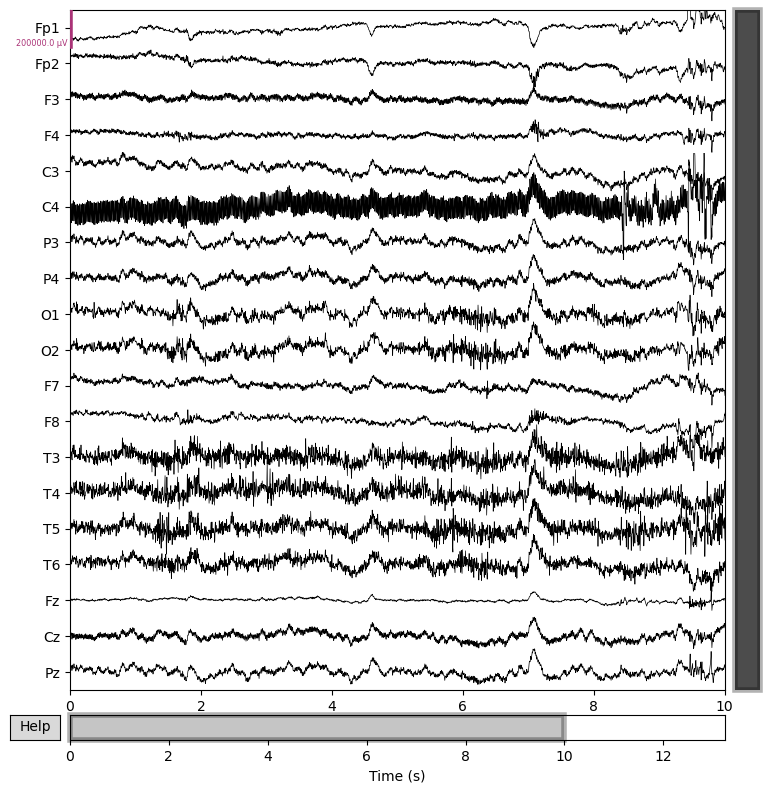

In [47]:
# create an MNE RawArray
sfreq = 250 # sampling frequency from the data.txt header
ch_names = eeg_labels['label'].tolist()
ch_types = ['eeg'] * len(ch_names)

info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
raw = mne.io.RawArray(eeg_data, info)

# plot all but A1 and A2
channels_to_plot = [ch for ch in raw.info['ch_names'] if ch not in ['A1', 'A2']]
raw_selected = raw.copy().pick_channels(channels_to_plot)
raw_selected.plot(scalings={'eeg': 10e-2})